In [9]:
#######################################################################
#####                                                             #####
#####     SPARSE IDENTIFICATION OF NONLINEAR DYNAMICS (SINDy)     #####
#####     Application to the Lotka-Volterra system                #####
#####                                                             #####
#######################################################################

"""

This small example illustrates the identification of a nonlinear
dynamical system using the data-driven approach SINDy with constraints
by Loiseau & Brunton (submitted to JFM Rapids).

Note: The sklearn python package is required for this example.
----

Contact: loiseau@mech.kth.se

"""


#--> Import standard python libraries
from math import *
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#--> Import some features of scipy to simulate the systems
#    or for matrix manipulation.
from scipy.integrate import odeint
from scipy.linalg import block_diag

#--> Import the PolynomialFeatures function from the sklearn
#    package to easily create the library of candidate functions
#    that will be used in the sparse regression problem.
from sklearn.preprocessing import PolynomialFeatures

#--> Import the sparse identification python package containing
#    the class to create sindy estimators.
import sparse_identification as sp
from sparse_identification.utils import derivative as spder
from sparse_identification.solvers import hard_threshold_lstsq_solve
from sparse_identification.utils import derivative
from sparse_identification import sindy

#--> Defines various functions used in this script.

def Lotka_Volterra(x0, r, a, time):
#     def dynamical_system(y,t):
#         dy = np.zeros_like(y)
#         for i in range(4):
#             dy[i] = r[i]*y[i]*(1-a[i][0]*y[0]-a[i][1]*y[1]-a[i][2]*y[2]-a[i][3]*y[3])
#         return dy
    def dynamical_system(y,t):
        return (r + a @ y) * y

    x = odeint(dynamical_system, x0, time, mxstep=5000000)
    dt = time[1] - time[0]
    xdot = spder(x, dt)

    return x, xdot

def constraints(library):

    """

    This function illustrates how to impose some
    user-defined constraints for the sparse identification.

    Input
    -----

    library : library object used for the sparse identification.

    Outputs
    -------

    C : two-dimensional numpy array.
        Constraints to be imposed on the regression coefficients.

    d : one-dimensional numpy array.
        Value of the constraints.

    """

    #--> Recover the number of input and output features of the library.
    m = library.n_input_features_
    n = library.n_output_features_

    #--> Initialise the user-defined constraints matrix and vector.
    #    In this example, two different constraints are imposed.
    C = np.zeros((2, m*n))
    d = np.zeros((2,1))

    #--> Definition of the first constraint:
    #    In the x-equation, one imposes that xi[2] = -xi[1]
    #    Note: xi[0] corresponds to the bias, xi[1] to the coefficient
    #    for x(t) and xi[2] to the one for y(t).
    C[0, 1] = 1
    C[0, 2] = 1

    #--> Definition of the second constraint:
    #    In the y-equation, one imposes that xi[1] = 28
    #    Note: the n+ is because the coefficient xi[1] for
    #    the y-equation is the n+1th entry of the regression
    #    coefficients vector.
    C[1, n+1] = 1
    d[1] = 28

    return C, d

def Identified_Model(y, t, library, estimator):

    '''
    Simulates the model from Sparse identification.

    Inputs
    ------

    library: library object used in the sparse identification
             (e.g. poly_lib = PolynomialFeatures(degree=3) )

    estimator: estimator object obtained from the sparse identification

    Output
    ------

    dy : numpy array object containing the derivatives evaluated using the
         model identified from sparse regression.

    '''

    dy = np.zeros_like(y)

    lib = library.fit_transform(y.reshape(1,-1))
    Theta = block_diag(lib, lib, lib, lib)
    dy = Theta.dot(estimator.coef_)

    return dy

def perturb_parameters(p, mean=0, stdev=0):
    return p + np.random.normal(mean, stdev, size=p.shape)

In [124]:
# true_r = np.array([1, 0.5, 1.5, 1])
# true_a = np.array([[-1, -1, -1.5, 0], 
#                   [0, -0.5, -0.25, -0.75], 
#                   [-3, 0, -1.5, -0.75], 
#                   [-1, -0.5, -0.5, -1]])

true_r = np.array([1, 0.72, 1.53, 1.27])
true_a = np.array([[-1, -1.09, -1.52, 0], 
                  [0, -1*0.72, -0.44*0.72, -1.36*0.72], 
                  [-2.33*1.53, 0, -1.53, -0.47*1.53], 
                  [-1.21*1.27, -0.51*1.27, -0.35*1.27, -1.27]])

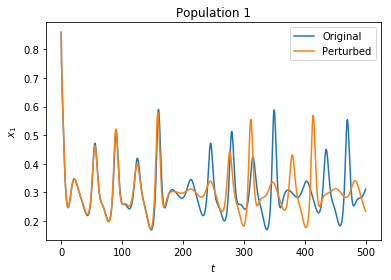

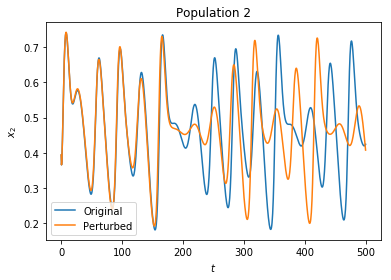

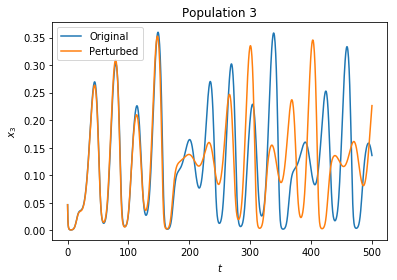

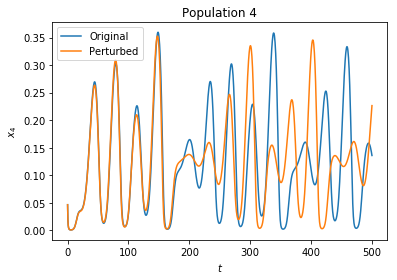

In [125]:
# Verify chaotic system
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 500, 1000)

x0 = np.random.uniform(0, 1, 4)
while True:
    x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
    if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
    break
a[0, 3] += 0.01
x_pert, dx_pert = Lotka_Volterra(x0, r, a, t)
plt.plot(t, x_temp[:, 0], label="Original")
plt.plot(t, x_pert[:, 0], label="Perturbed")
plt.legend()
plt.ylabel("$x_{1}$")
plt.xlabel("$t$")
plt.title("Population 1")
plt.show()
plt.plot(t, x_temp[:, 1], label="Original")
plt.plot(t, x_pert[:, 1], label="Perturbed")
plt.legend()
plt.ylabel("$x_{2}$")
plt.xlabel("$t$")
plt.title("Population 2")
plt.show()
plt.plot(t, x_temp[:, 2], label="Original")
plt.plot(t, x_pert[:, 2], label="Perturbed")
plt.legend()
plt.ylabel("$x_{3}$")
plt.xlabel("$t$")
plt.title("Population 3")
plt.show()
plt.plot(t, x_temp[:, 2], label="Original")
plt.plot(t, x_pert[:, 2], label="Perturbed")
plt.legend()
plt.ylabel("$x_{4}$")
plt.xlabel("$t$")
plt.title("Population 4")
plt.show()

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


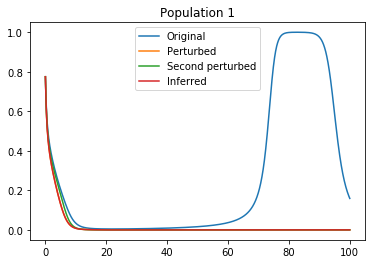

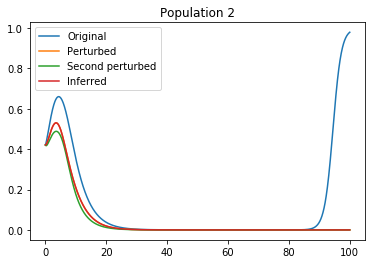

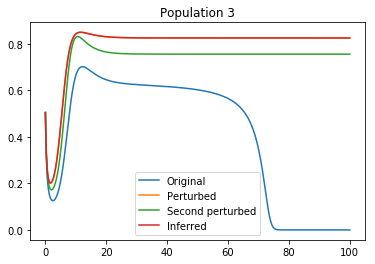

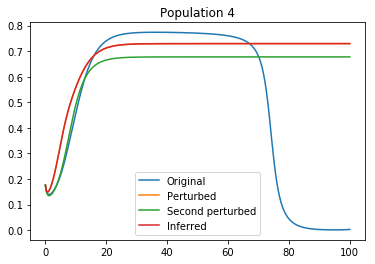

In [19]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 100, 2000)

while True:
    x0 = np.random.uniform(0, 1, 4)
    x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
    if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
    x_pert, dx_pert = Lotka_Volterra(x0, r + np.random.normal(0, 0.1, r.shape), a + np.random.normal(0, 0.1, a.shape), t)
    x_pert2, dx_pert2 = Lotka_Volterra(x0, r + np.random.normal(0, 0.1, r.shape), a + np.random.normal(0, 0.1, a.shape), t)
    library = PolynomialFeatures(degree=2, include_bias=True)
    Theta = library.fit_transform(np.concatenate([x_pert]))
    n_lib = library.n_output_features_
    A = block_diag(Theta, Theta, Theta, Theta)
    b = np.concatenate([dx_pert]).flatten(order='F')
    shols = sindy(l1=0.1, solver='lstsq')
    shols.fit(A, b)
    x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
    plt.plot(t, x_temp[:, 0], label="Original")
    plt.plot(t, x_pert[:, 0], label="Perturbed")
    plt.plot(t, x_pert2[:, 0], label="Second perturbed")
    plt.plot(t, x_ident[:, 0], label="Inferred")
    plt.legend()
    plt.title("Population 1")
    plt.show()
    plt.plot(t, x_temp[:, 1], label="Original")
    plt.plot(t, x_pert[:, 1], label="Perturbed")
    plt.plot(t, x_pert2[:, 1], label="Second perturbed")
    plt.plot(t, x_ident[:, 1], label="Inferred")
    plt.legend()
    plt.title("Population 2")
    plt.show()
    plt.plot(t, x_temp[:, 2], label="Original")
    plt.plot(t, x_pert[:, 2], label="Perturbed")
    plt.plot(t, x_pert2[:, 2], label="Second perturbed")
    plt.plot(t, x_ident[:, 2], label="Inferred")
    plt.title("Population 3")
    plt.legend()
    plt.show()
    plt.plot(t, x_temp[:, 3], label="Original")
    plt.plot(t, x_pert[:, 3], label="Perturbed")
    plt.plot(t, x_pert2[:, 3], label="Second perturbed")
    plt.plot(t, x_ident[:, 3], label="Inferred")
    plt.title("Population 4")
    plt.legend()
    plt.show()
    break

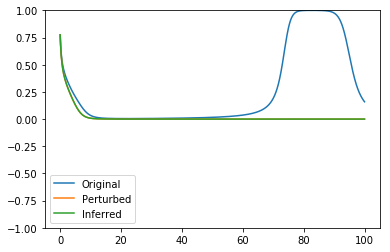

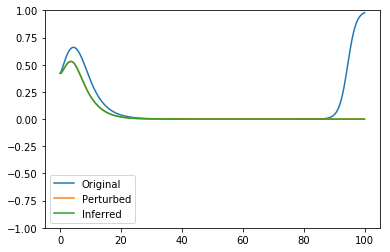

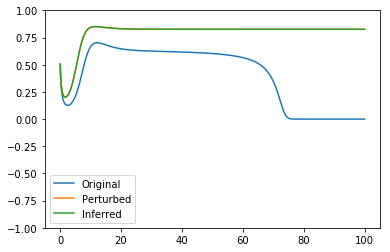

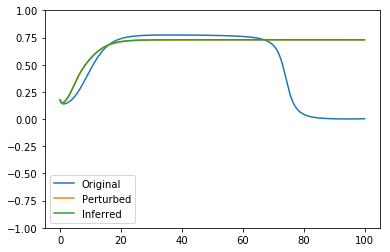

In [20]:
plt.plot(t, x_temp[:, 0], label="Original")
plt.plot(t, x_pert[:, 0], label="Perturbed")
plt.plot(t, x_ident[:, 0], label="Inferred")
plt.ylim([-1, 1])
plt.legend()
plt.show()
plt.plot(t, x_temp[:, 1], label="Original")
plt.plot(t, x_pert[:, 1], label="Perturbed")
plt.plot(t, x_ident[:, 1], label="Inferred")
plt.ylim([-1, 1])
plt.legend()
plt.show()
plt.plot(t, x_temp[:, 2], label="Original")
plt.plot(t, x_pert[:, 2], label="Perturbed")
plt.plot(t, x_ident[:, 2], label="Inferred")
plt.ylim([-1, 1])
plt.legend()
plt.show()
plt.plot(t, x_temp[:, 3], label="Original")
plt.plot(t, x_pert[:, 3], label="Perturbed")
plt.plot(t, x_ident[:, 3], label="Inferred")
plt.ylim([-1, 1])
plt.legend()
plt.show()

## Infinity norm between trajectories
### Takes multiple starting conditions, compares inferred trajectory to last used `noisy` trajectory. Uses 5 trajectories.

1e-05


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


1.20679264064e-05
1.4563484775e-05
1.75751062485e-05
2.12095088792e-05
2.5595479227e-05
3.08884359648e-05
3.72759372031e-05
4.49843266897e-05
5.42867543932e-05
6.5512855686e-05
7.90604321091e-05
9.5409547635e-05
0.000115139539933
0.000138949549437
0.000167683293681
0.000202358964773
0.000244205309455
0.000294705170255
0.000355648030622
0.000429193426013
0.000517947467923
0.000625055192527
0.000754312006335
0.000910298177992
0.00109854114199
0.00132571136559
0.00159985871961
0.00193069772888
0.00232995181052
0.00281176869797
0.0033932217719
0.00409491506238
0.00494171336132
0.00596362331659
0.00719685673001
0.00868511373751
0.0104811313415
0.0126485521686
0.0152641796718
0.0184206996933
0.0222299648253
0.0268269579528
0.0323745754282
0.0390693993705
0.0471486636346
0.0568986602902


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Failure
0.0686648845004
Failure
0.0828642772855
Failure
0.1


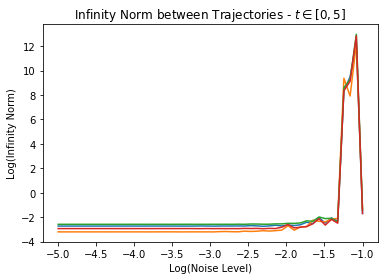

In [70]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 5, 100)

initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    # get working starting conditions
    while total < 5:
        x0 = np.random.uniform(0, 1, 4)
        x_t, dx_t = Lotka_Volterra(x0, r, a, t)
        if (np.max(np.abs(x_t)) > 1 or np.any(np.isnan(x_t)) or np.all(x_temp == 0)):
            continue
        total += 1
        initials[i].append(x0)

diff = []
noise_levels = np.logspace(-5, -1, 50)
for noise in noise_levels:
    tmp_diff = []
    i = 0
    print(noise)
    for i in range(10):
        x_cat, dx_cat = [], []
        for x0 in initials[i]:
            x_t, dx_t = Lotka_Volterra(x0, r + np.random.normal(0, noise, r.shape),
                                           a + np.random.normal(0, noise, a.shape), t)
            x_cat.append(x_t)
            dx_cat.append(dx_t)
        x, dx = np.concatenate(x_cat), np.concatenate(dx_cat)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        shols.fit(A, b)
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_t.T), axis=1)
        if (np.any(inf_norm > 10**4)):
            print("Failure")
        tmp_diff.append(inf_norm)
    diff.append(np.mean(tmp_diff, axis=0))
plt.plot(np.log10(noise_levels), np.log10(diff))
plt.title('Infinity Norm between Trajectories - $t \in [0, 5]$')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.show()

## Infinity norm between trajectories
### For each difference, takes a single starting point and its Lotka-Volterra trajectory. Then calculates the difference between the perturbed trajectories and this original one. Uses 5 trajectories.

1e-05


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':
/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Failure
Failure
1.20679264064e-05
Failure
Failure
1.4563484775e-05
Failure
Failure
1.75751062485e-05
Failure
Failure
2.12095088792e-05
Failure
Failure
2.5595479227e-05
Failure
Failure
3.08884359648e-05
Failure
Failure
3.72759372031e-05
Failure
Failure
4.49843266897e-05
Failure
Failure
5.42867543932e-05
Failure
Failure
6.5512855686e-05
Failure
Failure
7.90604321091e-05
Failure
Failure
9.5409547635e-05
Failure
Failure
0.000115139539933
Failure
Failure
0.000138949549437
Failure
Failure
0.000167683293681
Failure
Failure
0.000202358964773
Failure
Failure
0.000244205309455
Failure
Failure
0.000294705170255
Failure
Failure
0.000355648030622
Failure
Failure
0.000429193426013
Failure
Failure
0.000517947467923
Failure
Failure
0.000625055192527
Failure
Failure
0.000754312006335
Failure
Failure
0.000910298177992
Failure
Failure
Failure
0.00109854114199
Failure
Failure
0.00132571136559
Failure
Failure
0.00159985871961
Failure
Failure
Failure
0.00193069772888
Failure
Failure
0.00232995181052
Failure

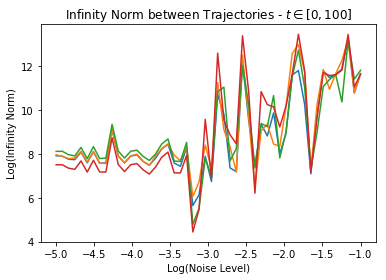

In [30]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 100, 2000)

initial_pts = []
initial_traj = []

total = 0
while total < 10:
    x0 = np.random.uniform(0, 1, 4)
    x_t, dx_t = Lotka_Volterra(x0, r, a, t)
    if (np.max(np.abs(x_t)) > 1 or np.any(np.isnan(x_t)) or np.all(x_temp == 0)):
        continue
    total += 1
    initial_pts.append(x0)
    initial_traj.append(x_t)

diff = []
noise_levels = np.logspace(-5, -1, 50)
for noise in noise_levels:
    tmp_diff = []
    print(noise)
    for i in range(10):
        x0 = initial_pts[i]
        x_cat, dx_cat = [], []
        for j in range(5):
            x_t, dx_t = Lotka_Volterra(x0, r + np.random.normal(0, noise, r.shape),
                                           a + np.random.normal(0, noise, a.shape), t)
            x_cat.append(x_t)
            dx_cat.append(dx_t)
        x, dx = np.concatenate(x_cat), np.concatenate(dx_cat)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        shols.fit(A, b)
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        x_orig = initial_traj[i]
        inf_norm = np.max(np.abs(x_ident.T - x_orig.T), axis=1)
        if (np.any(inf_norm > 10**4)):
            print("Failure")
        tmp_diff.append(inf_norm)
    diff.append(np.mean(tmp_diff, axis=0))
    
plt.plot(np.log10(noise_levels), np.log10(diff))
plt.title('Infinity Norm between Trajectories - $t \in [0, 100]$')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.show()

## Infinity norm between trajectories
### Same starting point, multiple perturbations, same noise

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


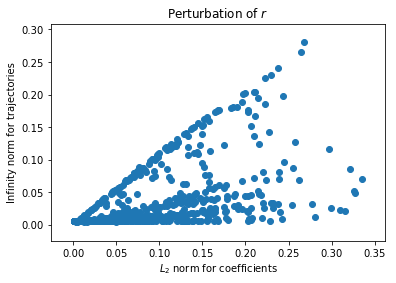

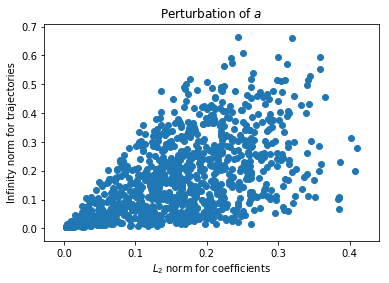

In [442]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 10, 100)

initial_pt = None
initial_traj = None

prob = 0.8
def perturb_r(tr):
    for i in range(len(tr)):
        if np.random.rand() > prob:
            tr[i] += np.random.normal(0, 0.1)
        else:
            tr[i] += np.random.normal(0, 0.001)
    return tr

def perturb_a(ta):
    for i in range(len(ta)):
        for j in range(len(ta[0])):
            if np.random.rand() > prob:
                ta[i, j] += np.random.normal(0, 0.1)
            else:
                ta[i, j] += np.random.normal(0, 0.001)
    return ta

while True:
    x0 = np.random.uniform(0, 1, 4)
    x_t, dx_t = Lotka_Volterra(x0, r, a, t)
    if (np.max(np.abs(x_t)) > 1 or np.any(np.isnan(x_t)) or np.all(x_temp == 0)):
        continue
    initial_pt = x0
    initial_traj = x_t
    break

perturbed_r_by = []
inf_norm_r = []

perturbed_a_by = []
inf_norm_a = []
    
for i in range(1000):
    p_r = perturb_r(r.copy())
    x_t, dx_t = Lotka_Volterra(initial_pt, p_r, a, t)
    library = PolynomialFeatures(degree=2, include_bias=True)
    Theta = library.fit_transform(x_t)
    n_lib = library.n_output_features_
    A = block_diag(Theta, Theta, Theta, Theta)
    b = dx_t.flatten(order='F')
    shols = sindy(l1=0.01, solver='lstsq')
    shols.fit(A, b)
    x_ident = odeint(Identified_Model, initial_pt, t, args=(library, shols))
    inf_norm = np.max(np.abs(initial_traj - x_ident))
    perturbed_r_by.append(np.linalg.norm(p_r - r))
    inf_norm_r.append(inf_norm)
    
for i in range(1000):
    p_a = perturb_a(a.copy())
    x_t, dx_t = Lotka_Volterra(initial_pt, r, p_a, t)
    library = PolynomialFeatures(degree=2, include_bias=True)
    Theta = library.fit_transform(x_t)
    n_lib = library.n_output_features_
    A = block_diag(Theta, Theta, Theta, Theta)
    b = dx_t.flatten(order='F')
    shols = sindy(l1=0.01, solver='lstsq')
    shols.fit(A, b)
    x_ident = odeint(Identified_Model, initial_pt, t, args=(library, shols))
    inf_norm = np.max(np.abs(initial_traj - x_ident))
    perturbed_a_by.append(np.linalg.norm(p_a - a))
    inf_norm_a.append(inf_norm)
    
plt.scatter(perturbed_r_by, inf_norm_r)
plt.title("Perturbation of $r$")
plt.xlabel("$L_{2}$ norm for coefficients")
plt.ylabel("Infinity norm for trajectories")
plt.show()

plt.scatter(perturbed_a_by, inf_norm_a)
plt.title("Perturbation of $a$")
plt.xlabel("$L_{2}$ norm for coefficients")
plt.ylabel("Infinity norm for trajectories")
plt.show()

## Infinity norm as a function of # data points in time

1000


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


1100


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


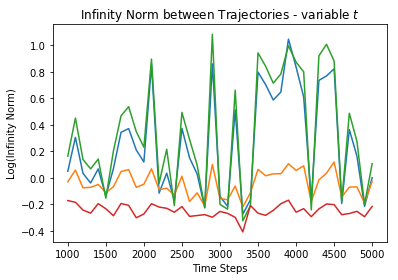

In [42]:
r = true_r.copy()
a = true_a.copy()
diff = []

time_steps = np.arange(1000, 5100, 100)

for num_points in time_steps:
    print(num_points)
    num_points = np.floor(num_points)
    t = np.linspace(0, 100, num_points)
    
    initials = [[] for _ in range(10)]
    for i in range(10):
        total = 0
        while total < 5:
            x0 = np.random.uniform(0, 1, 4)
            x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
            if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
                continue
            total += 1
            initials[i].append(x0)

    i = 0
    points_diff = []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
            x.append(x_temp)
            dx.append(dx_temp)

        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        for x0 in initials[i]:
            x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
            inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
            if not (np.any(inf_norm > 10**5)):
                break
        points_diff.append(inf_norm)
        i += 1
    diff.append(np.mean(points_diff, axis=0))

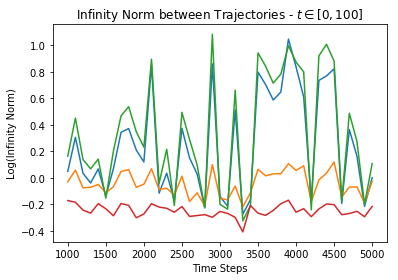

In [43]:
plt.plot(time_steps, np.log10(diff))
plt.title('Infinity Norm between Trajectories - $t \in [0, 100]$')
plt.xlabel('Time Steps')
plt.ylabel('Log(Infinity Norm)')
plt.show()

## Infinity norm between trajectories inferred from perturbing one of each parameters `r` and `a` via 0-mean Gaussian

In [31]:
r = true_r.copy()
a = true_a.copy()
t = np.linspace(0, 5, 100)
noise_level = np.logspace(-5, -1, 50)
initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(0, 1, 4)
        x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
        if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)
        
r_diff = []
a_diff = []

for noise in noise_level:
    print(noise)
    i = 0
    noise_diff = []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            r_p = r + np.random.normal(0, noise, r.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r_p, a, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
        i += 1
    r_diff.append(np.mean(noise_diff, axis=0))
    
    i = 0
    noise_diff = []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            a_p = a + np.random.normal(0, noise, a.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r, a_p, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        x_ident = odeint(Identified_Model, x0, t, args=(library, shols))
        inf_norm = np.max(np.abs(x_ident.T - x_temp.T), axis=1)
        noise_diff.append(inf_norm)
        i += 1
    a_diff.append(np.mean(noise_diff, axis=0))

1e-05


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


1.20679264064e-05
1.4563484775e-05


KeyboardInterrupt: 

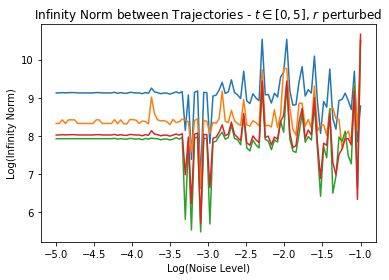

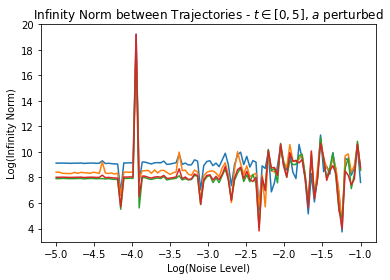

In [16]:
plt.title('Infinity Norm between Trajectories - $t \in [0, 100]$, $r$ perturbed')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.plot(np.log10(noise_level), np.log10(r_diff), label="$r$ perturbed")
plt.savefig('r_b1.png')
plt.show()

plt.title('Infinity Norm between Trajectories - $t \in [0, 100]$, $a$ perturbed')
plt.xlabel('Log(Noise Level)')
plt.ylabel('Log(Infinity Norm)')
plt.plot(np.log10(noise_level), np.log10(a_diff), label="$a$ perturbed")
plt.savefig('r_b2.png')
plt.show()

## Inferred coefficient distance by perturbing parameters `r` and `a` by 0-mean Gaussian

In [86]:
def make_coefficients(r, a, num_terms):
    num_vars = 4
    coeffs = np.zeros((num_vars, num_terms))
    for i in range(num_vars):
        coeffs[i, i+1] = r[i]
    coeffs[0, [5, 6, 7, 8]] = a[0]
    coeffs[1, [6, 9, 10, 11]] = a[1]
    coeffs[2, [7, 10, 12, 13]] = a[2]
    coeffs[3, [8, 11, 13, 14]] = a[3]

    return coeffs.ravel()

r = true_r.copy()
a = true_a.copy()
true_coeffs = make_coefficients(r, a, 15)
t = np.linspace(0, 100, 2000)
noise_level = np.logspace(-5, -1, 50)
dist, sparsity = [], []

initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(0, 1, 4)
        x_temp, dx_temp = Lotka_Volterra(x0, r, a, t)
        if np.max(np.abs(x_temp)) > 1 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)

for noise in noise_level:
    print(noise)
    i = 0
    noise_dist, noise_sparsity = [], []
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            r_p = r + np.random.normal(0, noise, r.shape)
            a_p = a + np.random.normal(0, noise, a.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, r_p, a_p, t)
            x.append(x_temp)
            dx.append(dx_temp)
        
        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.1, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        coefs = shols.coef_
        noise_dist.append(np.linalg.norm(coefs - true_coeffs))
        num_mismatch = np.sum([coefs[i] != 0 and true_coeffs[i] == 0 
                               for i in range(len(coefs))])
        noise_sparsity.append(num_mismatch)
        i += 1
    dist.append(np.mean(noise_dist))
    sparsity.append(np.mean(noise_sparsity))

1e-05


/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


1.20679264064e-05
1.4563484775e-05
1.75751062485e-05
2.12095088792e-05
2.5595479227e-05
3.08884359648e-05
3.72759372031e-05
4.49843266897e-05
5.42867543932e-05
6.5512855686e-05
7.90604321091e-05
9.5409547635e-05
0.000115139539933
0.000138949549437
0.000167683293681
0.000202358964773
0.000244205309455
0.000294705170255
0.000355648030622
0.000429193426013
0.000517947467923
0.000625055192527
0.000754312006335
0.000910298177992
0.00109854114199
0.00132571136559
0.00159985871961
0.00193069772888
0.00232995181052
0.00281176869797
0.0033932217719
0.00409491506238
0.00494171336132
0.00596362331659
0.00719685673001
0.00868511373751
0.0104811313415
0.0126485521686
0.0152641796718
0.0184206996933
0.0222299648253
0.0268269579528
0.0323745754282
0.0390693993705
0.0471486636346
0.0568986602902
0.0686648845004
0.0828642772855
0.1


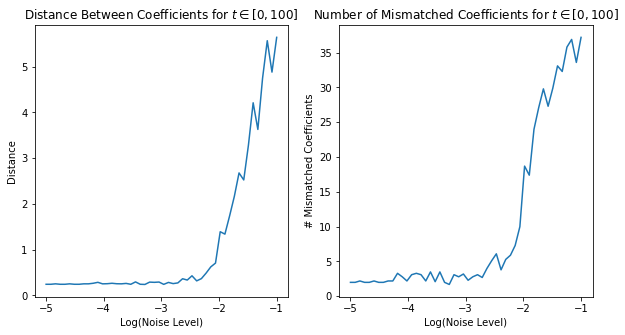

In [87]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.log10(noise_level), dist)
ax[0].set_title('Distance Between Coefficients for $t \in [0, 100]$')
ax[0].set_xlabel('Log(Noise Level)')
ax[0].set_ylabel('Distance')
ax[1].plot(np.log10(noise_level), sparsity)
ax[1].set_title('Number of Mismatched Coefficients for $t \in [0, 100]$')
ax[1].set_xlabel('Log(Noise Level)')
ax[1].set_ylabel('# Mismatched Coefficients')
plt.show()

# Other stuff below

In [23]:
import numpy as np
np.random.seed(1337)
from sparse_identification import sindy
from scipy.linalg import block_diag
from scipy.integrate import odeint
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from Lotka_Volterra import Lotka_Volterra, Identified_Model

def make_coefficients(alpha, beta, num_terms):
    '''
    Turn Lotka-Volterra coefficients into sklearn PolynomialFeatures coefficients for
    3D system. 
    '''
    num_vars = 3
    coeffs = np.zeros((num_vars, num_terms))
    for i in range(num_vars):
        coeffs[i, i+1] = alpha[i]
    coeffs[0, 4:7] = beta[0]
    coeffs[1, [5, 7, 8]] = beta[1]
    coeffs[2, [6, 8, 9]] = beta[2]
    
    return coeffs.ravel()

alpha = np.array([1, -1, -1])
beta = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
true_coeffs = make_coefficients(alpha, beta, 10)
t = np.linspace(0, 5, 2000)
t_extended = np.linspace(5, 10, 2000)
noise_level = np.logspace(-5, -1, 50)
dist, sparsity = [], []

initials = [[] for _ in range(10)]
for i in range(10):
    total = 0
    while total < 5:
        x0 = np.random.uniform(-2, 2, 3) # Initial condition.
        x_temp, dx_temp = Lotka_Volterra(x0, alpha, beta, t)
        if np.max(np.abs(x_temp)) > 10 or np.any(np.isnan(x_temp)) or np.all(x_temp == 0):
            continue
        total += 1
        initials[i].append(x0)
        
for noise in noise_level:
    noise_dist, noise_sparsity = [], []
    i = 0
    while i < 10:
        x, dx = [], []
        for x0 in initials[i]:
            alpha_perturb = alpha + np.random.normal(0, noise, alpha.shape)
            beta_perturb = beta + np.random.normal(0, noise, beta.shape)
            x_temp, dx_temp = Lotka_Volterra(x0, alpha_perturb, beta_perturb, t, noise=noise)
            x.append(x_temp)
            dx.append(dx_temp)

        x, dx = np.concatenate(x), np.concatenate(dx)
        library = PolynomialFeatures(degree=2, include_bias=True)
        Theta = library.fit_transform(x)
        print(library.powers_)
        print(Theta)
        n_lib = library.n_output_features_
        A = block_diag(Theta, Theta, Theta)
        b = dx.flatten(order='F')
        shols = sindy(l1=0.01, solver='lstsq')
        try:
            shols.fit(A, b)
        except:
            continue
        coefs = shols.coef_
        noise_dist.append(np.linalg.norm(coefs - true_coeffs))
        noise_sparsity.append(np.count_nonzero(coefs))
        i += 1
    dist.append(np.mean(noise_dist))
    sparsity.append(np.mean(noise_sparsity))

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.91842325e+00   1.31828053e+00 ...,   1.73786355e+00
    1.38943754e+00   1.11086781e+00]
 [  1.00000000e+00   1.91686962e+00   1.31785231e+00 ...,   1.73673471e+00
    1.39008719e+00   1.11262957e+00]
 [  1.00000000e+00   1.91534367e+00   1.31738643e+00 ...,   1.73550700e+00
    1.39068924e+00   1.11438131e+00]
 ..., 
 [  1.00000000e+00  -5.15872653e+00   2.40397987e-05 ...,   5.77911921e-10
    9.98261879e-08   1.72435754e-05]
 [  1.00000000e+00  -5.17161740e+00  -2.46870100e-06 ...,   6.09448461e-12
   -1.02510024e-08   1.72423193e-05]
 [  1.00000000e+00  -5.18458103e+00  -4.86331496e-07 ...,   2.36518324e-13
   -2.01158979e-09   1.71085834e-05]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.38254140e+00   4.30638693e-01 ...,   1.85449684e-01
   -3.31949256e-02   5.94179003e-03]
 [  1.00000000e+00   1.384

/Users/richard/anaconda/envs/py35/lib/python3.5/site-packages/cvxopt/coneprog.py:4331: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   4.42011549e-01   1.15340676e+00 ...,   1.33034715e+00
    1.73203798e+00   2.25501710e+00]
 [  1.00000000e+00   4.41859597e-01   1.14746033e+00 ...,   1.31666522e+00
    1.72375356e+00   2.25670602e+00]
 [  1.00000000e+00   4.41705329e-01   1.14157506e+00 ...,   1.30319361e+00
    1.71553060e+00   2.25833307e+00]
 ..., 
 [  1.00000000e+00  -7.87707516e+00   1.15380094e-05 ...,   1.33125661e-10
   -3.83663324e-07   1.10570377e-03]
 [  1.00000000e+00  -7.89681791e+00   4.29958241e-05 ...,   1.84864089e-09
   -1.42608181e-06   1.10011054e-03]
 [  1.00000000e+00  -7.91658601e+00   1.03932348e-05 ...,   1.08019330e-10
   -3.43994083e-07   1.09546994e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          1.12208988  0.26969347 ...,  0.07273457  0.30193662
   1.25340297]
 [ 1.          1.12412821  0.26905331 ...,  0.07238968  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90160431e+00   4.32801287e-02 ...,   1.87316954e-03
    7.33777338e-02   2.87442845e+00]
 [  1.00000000e+00   1.90617259e+00   4.32087731e-02 ...,   1.86699807e-03
    7.30828297e-02   2.86079566e+00]
 [  1.00000000e+00   1.91074145e+00   4.30941401e-02 ...,   1.85710491e-03
    7.27133702e-02   2.84703044e+00]
 ..., 
 [  1.00000000e+00   2.92954757e-01   7.43434110e-01 ...,   5.52694276e-01
   -3.73108732e-01   2.51875461e-01]
 [  1.00000000e+00   2.93171807e-01   7.43034981e-01 ...,   5.52100983e-01
   -3.72663309e-01   2.51544457e-01]
 [  1.00000000e+00   2.93344412e-01   7.42645819e-01 ...,   5.51522813e-01
   -3.72240969e-01   2.51237729e-01]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.00906341  1.53265603 ...,  2.34903451 -0.56994455
   0.13828523]
 [ 1.         -0.00906486  1.53025456 ...,  2.34167901 -

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.38451566  0.89085973 ...,  0.79363105 -0.21054887
   0.05585823]
 [ 1.          0.38460088  0.89004744 ...,  0.79218445 -0.21029749
   0.05582669]
 [ 1.          0.38473592  0.88916472 ...,  0.7906139  -0.21003647
   0.05579881]
 ..., 
 [ 1.          0.70949981  0.8713823  ...,  0.75930711 -0.22475671
   0.06652852]
 [ 1.          0.70972901  0.87129934 ...,  0.75916254 -0.22466607
   0.06648753]
 [ 1.          0.70993963  0.8712432  ...,  0.75906471 -0.22457781
   0.06644386]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.91842348e+00   1.31830448e+00 ...,   1.73792669e+00
    1.38940424e+00   1.11077421e+00]
 [  1.00000000e+00   1.91688209e+00   1.31783620e+00 ...,   1.73669225e+00
    1.39008796e+00   1.11265800e+00]
 [  1.00000000e+00   1.91536397e+00   1.31735515e+00 ...,   1.73542458e+00
    1.39064931e+00 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.38255454e+00   4.30653993e-01 ...,   1.85462862e-01
   -3.31825135e-02   5.93692554e-03]
 [  1.00000000e+00   1.38453912e+00   4.31110168e-01 ...,   1.85855977e-01
   -3.31548445e-02   5.91449212e-03]
 [  1.00000000e+00   1.38650207e+00   4.31682798e-01 ...,   1.86350038e-01
   -3.31849406e-02   5.90952539e-03]
 ..., 
 [  1.00000000e+00  -8.34773252e+00   5.12580890e-06 ...,   2.62739169e-11
   -8.51810916e-09   2.76160513e-06]
 [  1.00000000e+00  -8.36858582e+00  -8.41764618e-06 ...,   7.08567672e-11
    1.41238394e-08   2.81529695e-06]
 [  1.00000000e+00  -8.38956219e+00   9.10833348e-06 ...,   8.29617388e-11
   -1.53363178e-08   2.83507369e-06]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.88528828  0.99249759 ...,  0.98505146  0.72714999
   0.53677105]
 [ 1.          0.88533903  0.99039072 ...,  0.98087378  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          1.12209296  0.26967163 ...,  0.07272279  0.30191104
   1.25339359]
 [ 1.          1.12414441  0.26903329 ...,  0.07237891  0.30064334
   1.24879497]
 [ 1.          1.12622146  0.26838985 ...,  0.07203311  0.2993776
   1.24424651]
 ..., 
 [ 1.          2.3028071   0.84568479 ...,  0.71518276  0.05965989
   0.00497677]
 [ 1.          2.30372823  0.8483643  ...,  0.71972199  0.05984128
   0.0049755 ]
 [ 1.          2.30457986  0.85097222 ...,  0.72415372  0.06003271
   0.00497674]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.14137658e-01   1.36811787e-01 ...,   1.87174650e-02
   -1.92295126e-01   1.97555680e+00]
 [  1.00000000e+00   1.14390138e-01   1.36991095e-01 ...,   1.87665602e-02
   -1.92128801e-01   1.96698146e+00]
 [  1.00000000e+00   1.14602539e-01   1.37200538e-01 ...,   1.88239876e-02
   -1.92007496e-01  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.00902102  1.5326961  ...,  2.34915733 -0.5700065
   0.13830807]
 [ 1.         -0.00901326  1.53025519 ...,  2.34168094 -0.56989247
   0.13869414]
 [ 1.         -0.00904204  1.52786889 ...,  2.33438333 -0.56965575
   0.13901216]
 ..., 
 [ 1.          1.5294005   1.0003938  ...,  1.00078776  0.6192012
   0.38310833]
 [ 1.          1.52945094  1.00012536 ...,  1.00025073  0.61912964
   0.38322542]
 [ 1.          1.52938664  0.99990106 ...,  0.99980214  0.61894756
   0.3831719 ]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.38456049  0.89085369 ...,  0.7936203  -0.21052188
   0.05584467]
 [ 1.          0.38460563  0.89000024 ...,  0.79210042 -0.21030837
   0.05583839]
 [ 1.          0.38473802  0.88916744 ...,  0.79061874 -0.21003628
   0.05579837]
 ..., 
 [ 1.          0.7096546   0.87146831 ...,  0.75945702 -0.22472486


[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.88536359  0.9924865  ...,  0.98502945  0.72708186
   0.53668247]
 [ 1.          0.88527049  0.99041433 ...,  0.98092055  0.72565158
   0.5368123 ]
 [ 1.          0.88528958  0.98828676 ...,  0.97671072  0.7240655
   0.53677188]
 ..., 
 [ 1.          0.7914425   2.29750814 ...,  5.27854365  0.20690503
   0.00811013]
 [ 1.          0.78881753  2.2958505  ...,  5.27092951  0.20742336
   0.00816259]
 [ 1.          0.78630631  2.29409337 ...,  5.26286441  0.20798867
   0.00821972]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -5.11748633e-02   5.66347794e-01 ...,   3.20749824e-01
   -4.45589701e-02   6.19018834e-03]
 [  1.00000000e+00  -5.12122781e-02   5.65051083e-01 ...,   3.19282726e-01
   -4.44110797e-02   6.17742156e-03]
 [  1.00000000e+00  -5.12358191e-02   5.63705058e-01 ...,   3.17763392e-01
   -4.42480956e-02  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90161886e+00   4.32775744e-02 ...,   1.87294845e-03
    7.33729050e-02   2.87438941e+00]
 [  1.00000000e+00   1.90605797e+00   4.31347207e-02 ...,   1.86060413e-03
    7.29626737e-02   2.86119527e+00]
 [  1.00000000e+00   1.91066534e+00   4.31726231e-02 ...,   1.86387538e-03
    7.28448373e-02   2.84695552e+00]
 ..., 
 [  1.00000000e+00   2.94327813e-01   7.40865618e-01 ...,   5.48881864e-01
   -3.69829797e-01   2.49186733e-01]
 [  1.00000000e+00   2.94381763e-01   7.40349796e-01 ...,   5.48117821e-01
   -3.69293298e-01   2.48810629e-01]
 [  1.00000000e+00   2.94585583e-01   7.40018617e-01 ...,   5.47627553e-01
   -3.68864627e-01   2.48455565e-01]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.00904228  1.53270896 ...,  2.34919675 -0.57006754
   0.13833537]
 [ 1.         -0.00910306  1.53020634 ...,  2.34153146 -

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.88533074  0.99254614 ...,  0.98514785  0.72718335
   0.53676778]
 [ 1.          0.88531162  0.99022226 ...,  0.98054012  0.72551852
   0.53682365]
 [ 1.          0.88524487  0.9884031  ...,  0.97694069  0.7241587
   0.53678368]
 ..., 
 [ 1.          0.79257988  2.29736954 ...,  5.27790678  0.20631579
   0.00806498]
 [ 1.          0.78993599  2.2958243  ...,  5.27080922  0.20699353
   0.00812898]
 [ 1.          0.78745087  2.29400286 ...,  5.26244911  0.20722825
   0.00816037]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -5.11065406e-02   5.66391242e-01 ...,   3.20799039e-01
   -4.46521701e-02   6.21515669e-03]
 [  1.00000000e+00  -5.12872658e-02   5.64970116e-01 ...,   3.19191233e-01
   -4.44174959e-02   6.18097785e-03]
 [  1.00000000e+00  -5.13160688e-02   5.63605486e-01 ...,   3.17651144e-01
   -4.43088961e-02  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.14206211e-01   1.36798710e-01 ...,   1.87138871e-02
   -1.92256852e-01   1.97514803e+00]
 [  1.00000000e+00   1.14287972e-01   1.37005940e-01 ...,   1.87706275e-02
   -1.92139857e-01   1.96678158e+00]
 [  1.00000000e+00   1.14637969e-01   1.37182523e-01 ...,   1.88190447e-02
   -1.91968547e-01   1.95822496e+00]
 ..., 
 [  1.00000000e+00  -6.83678638e+00   6.62203236e-05 ...,   4.38513126e-09
    7.36234273e-07   1.23608821e-04]
 [  1.00000000e+00  -6.85378900e+00   6.99153811e-05 ...,   4.88816051e-09
    7.62423549e-07   1.18917876e-04]
 [  1.00000000e+00  -6.87103741e+00  -1.44225044e-05 ...,   2.08008632e-10
   -1.56927752e-07   1.18390852e-04]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90177900e+00   4.32973007e-02 ...,   1.87465624e-03
    7.34052157e-02   2.87430067e+00]
 [  1.00000000e+00   1.906

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.38464899  0.89100923 ...,  0.79389745 -0.21068244
   0.05591036]
 [ 1.          0.38433664  0.88997142 ...,  0.79204913 -0.21048965
   0.05593831]
 [ 1.          0.38473715  0.88913729 ...,  0.79056513 -0.20997659
   0.05577045]
 ..., 
 [ 1.          0.708593    0.87278794 ...,  0.76175878 -0.22615308
   0.06714096]
 [ 1.          0.70869259  0.8724393  ...,  0.76115034 -0.2257165
   0.06693545]
 [ 1.          0.70885665  0.87239683 ...,  0.76107622 -0.22569646
   0.06693008]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.91847967e+00   1.31837340e+00 ...,   1.73810841e+00
    1.38995440e+00   1.11153782e+00]
 [  1.00000000e+00   1.91696697e+00   1.31776566e+00 ...,   1.73650635e+00
    1.39008016e+00   1.11276464e+00]
 [  1.00000000e+00   1.91527862e+00   1.31729927e+00 ...,   1.73527737e+00
    1.39052019e+00  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.88548455  0.99260617 ...,  0.985267    0.72726626
   0.53682526]
 [ 1.          0.88524436  0.99031874 ...,  0.9807312   0.72557345
   0.53680034]
 [ 1.          0.8858938   0.9881492  ...,  0.97643884  0.72400342
   0.53682927]
 ..., 
 [ 1.          0.7909378   2.29694418 ...,  5.27595257  0.20693333
   0.00811634]
 [ 1.          0.78815272  2.29512321 ...,  5.26759053  0.20741173
   0.00816685]
 [ 1.          0.78569465  2.29350198 ...,  5.26015135  0.20766176
   0.00819813]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -5.11123806e-02   5.66240082e-01 ...,   3.20627831e-01
   -4.44869930e-02   6.17255385e-03]
 [  1.00000000e+00  -5.11914253e-02   5.64830660e-01 ...,   3.19033675e-01
   -4.44629099e-02   6.19668240e-03]
 [  1.00000000e+00  -5.09752317e-02   5.63530609e-01 ...,   3.17566747e-01
   -4.41950107e-02 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.14160041e-01   1.36559684e-01 ...,   1.86485472e-02
   -1.91914535e-01   1.97501652e+00]
 [  1.00000000e+00   1.14420129e-01   1.37033657e-01 ...,   1.87782231e-02
   -1.92183665e-01   1.96688265e+00]
 [  1.00000000e+00   1.14922618e-01   1.37388295e-01 ...,   1.88755437e-02
   -1.92293785e-01   1.95898461e+00]
 ..., 
 [  1.00000000e+00  -6.81499520e+00  -2.18885331e-05 ...,   4.79107883e-10
   -2.31944988e-07   1.12288859e-04]
 [  1.00000000e+00  -6.83190367e+00  -8.40500800e-05 ...,   7.06441594e-09
   -9.11301203e-07   1.17556765e-04]
 [  1.00000000e+00  -6.84913538e+00  -1.04224130e-04 ...,   1.08626693e-08
   -1.12275293e-06   1.16046444e-04]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90169453e+00   4.35092860e-02 ...,   1.89305797e-03
    7.37598951e-02   2.87393318e+00]
 [  1.00000000e+00   1.906

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.0093421   1.53282018 ...,  2.34953771 -0.57076349
   0.13865322]
 [ 1.         -0.00852823  1.53034903 ...,  2.34196817 -0.56979681
   0.13863058]
 [ 1.         -0.00904378  1.52771029 ...,  2.33389875 -0.57024089
   0.13932681]
 ..., 
 [ 1.          1.53088867  0.99973535 ...,  0.99947077  0.62001357
   0.38462038]
 [ 1.          1.53118822  0.9995161  ...,  0.99903244  0.6198896
   0.38463528]
 [ 1.          1.53111547  0.99928773 ...,  0.99857597  0.61981623
   0.38472001]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.3843337   0.89102571 ...,  0.79392682 -0.21071868
   0.05592752]
 [ 1.          0.3847684   0.88964104 ...,  0.79146119 -0.20986179
   0.05564641]
 [ 1.          0.38472293  0.88927342 ...,  0.79080722 -0.20992985
   0.05572855]
 ..., 
 [ 1.          0.71031633  0.87104388 ...,  0.75871745 -0.22457756

 [0 0 2]]
[[ 1.          0.88515208  0.99242099 ...,  0.98489941  0.72680621
   0.53634642]
 [ 1.          0.88554403  0.99036689 ...,  0.98082658  0.72563131
   0.53683374]
 [ 1.          0.88474501  0.98838184 ...,  0.97689867  0.72401178
   0.53658897]
 ..., 
 [ 1.          0.78803849  2.2997745  ...,  5.28896277  0.21093603
   0.00841262]
 [ 1.          0.78482704  2.29792573 ...,  5.28046266  0.21207865
   0.00851769]
 [ 1.          0.78257468  2.2969039  ...,  5.27576754  0.21145306
   0.00847505]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -5.06665779e-02   5.66319870e-01 ...,   3.20718195e-01
   -4.45825012e-02   6.19733910e-03]
 [  1.00000000e+00  -5.14260583e-02   5.65276972e-01 ...,   3.19538055e-01
   -4.42846314e-02   6.13738662e-03]
 [  1.00000000e+00  -5.14755260e-02   5.62932116e-01 ...,   3.16892568e-01
   -4.40953606e-02   6.13583601e-03]
 ..., 
 [  1.00000000e+00   1.14058254e+00   3.44016820e+00 ...

 [0 0 2]]
[[  1.00000000e+00   4.41785041e-01   1.15331250e+00 ...,   1.33012973e+00
    1.73288134e+00   2.25758261e+00]
 [  1.00000000e+00   4.42024890e-01   1.14705292e+00 ...,   1.31573040e+00
    1.72380672e+00   2.25844870e+00]
 [  1.00000000e+00   4.40895328e-01   1.14197790e+00 ...,   1.30411353e+00
    1.71652920e+00   2.25936810e+00]
 ..., 
 [  1.00000000e+00  -7.84341753e+00  -3.27809203e-04 ...,   1.07458873e-07
    1.09309016e-05   1.11191013e-03]
 [  1.00000000e+00  -7.86285522e+00  -4.29167592e-04 ...,   1.84184822e-07
    1.45071688e-05   1.14264544e-03]
 [  1.00000000e+00  -7.88269783e+00   8.26511699e-04 ...,   6.83121589e-07
   -2.73175604e-05   1.09241037e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          1.12205209  0.26992788 ...,  0.07286106  0.30205796
   1.25223288]
 [ 1.          1.1242059   0.26952131 ...,  0.07264174  0.30115919
   1.24855022]
 [ 1.          1.12598787  0.26835058 ...,  0.07201203 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.91831466e+00   1.31839282e+00 ...,   1.73815964e+00
    1.38822043e+00   1.10873359e+00]
 [  1.00000000e+00   1.91689297e+00   1.31736073e+00 ...,   1.73543930e+00
    1.39023498e+00   1.11369686e+00]
 [  1.00000000e+00   1.91436895e+00   1.31830031e+00 ...,   1.73791572e+00
    1.39111468e+00   1.11351778e+00]
 ..., 
 [  1.00000000e+00  -5.17711974e+00  -3.79851899e-04 ...,   1.44287465e-07
   -1.46399995e-06   1.48543454e-05]
 [  1.00000000e+00  -5.19041942e+00   6.97993283e-04 ...,   4.87194623e-07
    2.46393394e-06   1.24610785e-05]
 [  1.00000000e+00  -5.20397586e+00   7.75018878e-04 ...,   6.00654261e-07
    2.84521533e-06   1.34773876e-05]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.38210444e+00   4.31216651e-01 ...,   1.85947800e-01
   -3.33596952e-02   5.98484770e-03]
 [  1.00000000e+00   1.384

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   4.41813999e-01   1.15189059e+00 ...,   1.32685193e+00
    1.73127734e+00   2.25897189e+00]
 [  1.00000000e+00   4.42579660e-01   1.14718473e+00 ...,   1.31603280e+00
    1.72415071e+00   2.25883100e+00]
 [  1.00000000e+00   4.40902120e-01   1.14152548e+00 ...,   1.30308042e+00
    1.71582128e+00   2.25929469e+00]
 ..., 
 [  1.00000000e+00  -8.02452773e+00   3.82843311e-04 ...,   1.46569001e-07
   -1.24883797e-05   1.06406966e-03]
 [  1.00000000e+00  -8.04402587e+00  -5.32050687e-04 ...,   2.83077933e-07
    1.69876187e-05   1.01943371e-03]
 [  1.00000000e+00  -8.06567099e+00  -3.21408631e-04 ...,   1.03303508e-07
    1.05076685e-05   1.06880299e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          1.12190344  0.26993164 ...,  0.07286309  0.30261997
   1.2568619 ]
 [ 1.          1.12352341  0.27036155 ...,  0.07309537  

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.14494333e-01   1.36789504e-01 ...,   1.87113684e-02
   -1.92432684e-01   1.97902885e+00]
 [  1.00000000e+00   1.16230028e-01   1.38421527e-01 ...,   1.91605190e-02
   -1.94421284e-01   1.97278767e+00]
 [  1.00000000e+00   1.15150236e-01   1.38192892e-01 ...,   1.90972753e-02
   -1.93408682e-01   1.95875681e+00]
 ..., 
 [  1.00000000e+00  -6.74298797e+00   8.67271252e-04 ...,   7.52159424e-07
    7.91928157e-06   8.33799572e-05]
 [  1.00000000e+00  -6.76089192e+00  -9.92088003e-04 ...,   9.84238605e-07
   -1.07642080e-05   1.17723663e-04]
 [  1.00000000e+00  -6.77569199e+00  -4.86413435e-04 ...,   2.36598030e-07
   -5.77292022e-06   1.40857504e-04]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90122762e+00   4.30747724e-02 ...,   1.85543602e-03
    7.30461345e-02   2.87573255e+00]
 [  1.00000000e+00   1.906

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.00807611  1.53175577 ...,  2.34627575 -0.57130375
   0.13910896]
 [ 1.         -0.00809127  1.52881109 ...,  2.33726334 -0.57408103
   0.14100637]
 [ 1.         -0.00847561  1.52729358 ...,  2.33262568 -0.57036581
   0.13946394]
 ..., 
 [ 1.          1.53208705  0.99885576 ...,  0.99771282  0.62296952
   0.38898069]
 [ 1.          1.53265744  1.00079735 ...,  1.00159534  0.62486833
   0.3898385 ]
 [ 1.          1.53174066  0.99711324 ...,  0.99423481  0.62202357
   0.38915688]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.38383181  0.89054619 ...,  0.79307251 -0.2095764
   0.05538241]
 [ 1.          0.3848633   0.88916279 ...,  0.79061047 -0.20938308
   0.05545243]
 [ 1.          0.38504126  0.88932606 ...,  0.79090085 -0.20798358
   0.05469354]
 ..., 
 [ 1.          0.70450348  0.86991832 ...,  0.75675789 -0.22421185

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.37864205e+00   4.31304086e-01 ...,   1.86023215e-01
   -3.38424100e-02   6.15680529e-03]
 [  1.00000000e+00   1.38499971e+00   4.30926919e-01 ...,   1.85698010e-01
   -3.19068608e-02   5.48227614e-03]
 [  1.00000000e+00   1.38574836e+00   4.32139745e-01 ...,   1.86744759e-01
   -3.42551284e-02   6.28351675e-03]
 ..., 
 [  1.00000000e+00  -8.34547006e+00  -1.87486240e-03 ...,   3.51510900e-06
    5.78325304e-06   9.51492989e-06]
 [  1.00000000e+00  -8.36499529e+00   1.07121931e-03 ...,   1.14751081e-06
   -2.67362244e-06   6.22935914e-06]
 [  1.00000000e+00  -8.38685104e+00   5.42010611e-04 ...,   2.93775502e-07
   -7.47046249e-07   1.89967541e-06]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.88341982  0.99453479 ...,  0.98909945  0.7317092
   0.54129881]
 [ 1.          0.88461125  0.99029537 ...,  0.98068493  0

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -5.26661557e-02   5.70122214e-01 ...,   3.25039339e-01
   -4.40810209e-02   5.97815763e-03]
 [  1.00000000e+00  -5.10528170e-02   5.64369286e-01 ...,   3.18512691e-01
   -4.47411659e-02   6.28474777e-03]
 [  1.00000000e+00  -5.48581168e-02   5.64774963e-01 ...,   3.18970759e-01
   -4.64918386e-02   6.77645520e-03]
 ..., 
 [  1.00000000e+00   1.11389359e+00   3.44917029e+00 ...,   1.18967757e+01
   -1.07021330e-01   9.62745314e-04]
 [  1.00000000e+00   1.11185589e+00   3.44759309e+00 ...,   1.18858981e+01
   -1.14919991e-01   1.11111538e-03]
 [  1.00000000e+00   1.10358260e+00   3.44916676e+00 ...,   1.18967514e+01
   -1.19569747e-01   1.20175030e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   4.42212103e-01   1.15753484e+00 ...,   1.33988690e+00
    1.73703128e+00   2.25188983e+00]
 [  1.00000000e+00   4.404

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          1.11967283  0.26805738 ...,  0.07185476  0.29973546
   1.25031865]
 [ 1.          1.12273576  0.26818465 ...,  0.071923    0.29886744
   1.24190788]
 [ 1.          1.12531985  0.26752506 ...,  0.07156966  0.29854819
   1.24537448]
 ..., 
 [ 1.          2.30273372  0.8455611  ...,  0.71497358  0.05590118
   0.00437071]
 [ 1.          2.30708062  0.84973657 ...,  0.72205224  0.05715672
   0.00452445]
 [ 1.          2.30818628  0.85108143 ...,  0.7243396   0.05798315
   0.00464153]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.15923950e-01   1.35131218e-01 ...,   1.82604460e-02
   -1.89673709e-01   1.97016633e+00]
 [  1.00000000e+00   1.11760304e-01   1.38890990e-01 ...,   1.92907072e-02
   -1.94874823e-01   1.96862646e+00]
 [  1.00000000e+00   1.14398018e-01   1.38566211e-01 ...,   1.92005948e-02
   -1.94370843e-01 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.89979424e+00   4.32312752e-02 ...,   1.86894315e-03
    7.32906932e-02   2.87409797e+00]
 [  1.00000000e+00   1.90153293e+00   4.11531980e-02 ...,   1.69358571e-03
    6.96591199e-02   2.86515939e+00]
 [  1.00000000e+00   1.91069214e+00   4.56636964e-02 ...,   2.08517317e-03
    7.71511841e-02   2.85458555e+00]
 ..., 
 [  1.00000000e+00   3.12479883e-01   6.91908926e-01 ...,   4.78737962e-01
   -3.16012834e-01   2.08598689e-01]
 [  1.00000000e+00   3.12877242e-01   6.99468048e-01 ...,   4.89255550e-01
   -3.17986364e-01   2.06671805e-01]
 [  1.00000000e+00   3.11948332e-01   6.91896282e-01 ...,   4.78720465e-01
   -3.15584959e-01   2.08041799e-01]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.00496926  1.53117697 ...,  2.34450292 -0.57163607
   0.13937615]
 [ 1.         -0.0117044   1.53212297 ...,  2.34740079 -

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.8833146   0.99014586 ...,  0.98038883  0.73015172
   0.54378581]
 [ 1.          0.883075    0.99594949 ...,  0.99191538  0.72784158
   0.53407112]
 [ 1.          0.88822025  0.99015346 ...,  0.98040387  0.72548837
   0.53685363]
 ..., 
 [ 1.          0.75016736  2.30397383 ...,  5.30829543  0.24253303
   0.0110812 ]
 [ 1.          0.74276753  2.31211091 ...,  5.34585687  0.22957342
   0.00985884]
 [ 1.          0.73922835  2.30594241 ...,  5.3173704   0.24049258
   0.01087693]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -4.24159078e-02   5.64887576e-01 ...,   3.19097974e-01
   -4.71964898e-02   6.98064179e-03]
 [  1.00000000e+00  -4.43784220e-02   5.64959774e-01 ...,   3.19179546e-01
   -4.40941129e-02   6.09152691e-03]
 [  1.00000000e+00  -5.08464707e-02   5.63450467e-01 ...,   3.17476429e-01
   -4.03293654e-02 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.13329522e-01   1.43706365e-01 ...,   2.06515194e-02
   -2.01277273e-01   1.96172203e+00]
 [  1.00000000e+00   1.08396274e-01   1.33156071e-01 ...,   1.77305393e-02
   -1.87600420e-01   1.98493216e+00]
 [  1.00000000e+00   1.08647146e-01   1.33092579e-01 ...,   1.77136345e-02
   -1.86228332e-01   1.95786990e+00]
 ..., 
 [  1.00000000e+00  -6.69870104e+00   4.58462199e-03 ...,   2.10187588e-05
    3.65597025e-05   6.35913786e-05]
 [  1.00000000e+00  -6.71345287e+00   7.70376336e-04 ...,   5.93479699e-07
    1.10775248e-05   2.06766222e-04]
 [  1.00000000e+00  -6.72325104e+00  -8.63714965e-04 ...,   7.46003541e-07
   -9.82734545e-06   1.29458794e-04]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90511229e+00   4.66204194e-02 ...,   2.17346350e-03
    7.97106225e-02   2.92334485e+00]
 [  1.00000000e+00   1.906

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90040389e+00   4.97152790e-02 ...,   2.47160896e-03
    8.42051005e-02   2.86877862e+00]
 [  1.00000000e+00   1.91030038e+00   4.83312006e-02 ...,   2.33590495e-03
    8.16123846e-02   2.85139227e+00]
 [  1.00000000e+00   1.90483039e+00   4.35892168e-02 ...,   1.90001982e-03
    7.31615031e-02   2.81713142e+00]
 ..., 
 [  1.00000000e+00   3.59767786e-01   6.52860273e-01 ...,   4.26226537e-01
   -2.67675009e-01   1.68102884e-01]
 [  1.00000000e+00   3.51537634e-01   6.63156541e-01 ...,   4.39776598e-01
   -2.72612604e-01   1.68989511e-01]
 [  1.00000000e+00   3.52650552e-01   6.67125525e-01 ...,   4.45056466e-01
   -2.74231871e-01   1.68974332e-01]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -1.90157313e-03   1.53355299e+00 ...,   2.35178477e+00
   -5.78836495e-01   1.42466986e-01]
 [  1.00000000e+00  -7.280

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.3852132   0.89125633 ...,  0.79433784 -0.20207808
   0.05140829]
 [ 1.          0.37638441  0.8769174  ...,  0.76898413 -0.20866079
   0.05661927]
 [ 1.          0.37722047  0.8711629  ...,  0.75892481 -0.21179786
   0.05910775]
 ..., 
 [ 1.          0.73732254  0.86408728 ...,  0.74664684 -0.21982488
   0.06471999]
 [ 1.          0.73696794  0.87376994 ...,  0.7634739  -0.21314364
   0.0595046 ]
 [ 1.          0.7413478   0.87238656 ...,  0.76105831 -0.21227058
   0.05920545]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90153274e+00   1.29154686e+00 ...,   1.66809328e+00
    1.37767435e+00   1.13781803e+00]
 [  1.00000000e+00   1.92129016e+00   1.32106934e+00 ...,   1.74522419e+00
    1.39681216e+00   1.11795620e+00]
 [  1.00000000e+00   1.91184951e+00   1.31711194e+00 ...,   1.73478387e+00
    1.39360935e+00 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -7.41737398e-02   5.69509928e-01 ...,   3.24341558e-01
   -5.28953109e-02   8.62644288e-03]
 [  1.00000000e+00  -3.71647849e-02   5.75795202e-01 ...,   3.31540114e-01
   -4.63059542e-02   6.46751721e-03]
 [  1.00000000e+00  -6.52419640e-02   5.54306696e-01 ...,   3.07255914e-01
   -3.72373828e-02   4.51292429e-03]
 ..., 
 [  1.00000000e+00   1.14593499e+00   3.42214363e+00 ...,   1.17110670e+01
   -4.04919479e-02   1.40004138e-04]
 [  1.00000000e+00   1.12957450e+00   3.41688527e+00 ...,   1.16751049e+01
   -9.24358835e-02   7.31847176e-04]
 [  1.00000000e+00   1.11905955e+00   3.42932340e+00 ...,   1.17602590e+01
   -8.39172739e-02   5.98805594e-04]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   4.45862307e-01   1.15474129e+00 ...,   1.33342744e+00
    1.74195931e+00   2.27565606e+00]
 [  1.00000000e+00   4.396

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.88214577e+00   5.74527208e-02 ...,   3.30081513e-03
    9.72895688e-02   2.86755235e+00]
 [  1.00000000e+00   1.91123326e+00   1.77283406e-02 ...,   3.14294060e-04
    2.98403638e-02   2.83316622e+00]
 [  1.00000000e+00   1.89002973e+00   5.92604396e-02 ...,   3.51179970e-03
    9.99664219e-02   2.84563083e+00]
 ..., 
 [  1.00000000e+00   1.89139750e-01   8.94057178e-01 ...,   7.99338237e-01
   -6.17520975e-01   4.77059819e-01]
 [  1.00000000e+00   1.88754243e-01   9.28896795e-01 ...,   8.62849256e-01
   -6.16063871e-01   4.39862109e-01]
 [  1.00000000e+00   1.88556468e-01   9.14435887e-01 ...,   8.36192992e-01
   -6.00613521e-01   4.31403522e-01]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.02748304  1.53782307 ...,  2.36489981 -0.56354043
   0.13428806]
 [ 1.          0.0118534   1.52733788 ...,  2.33276101 -

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.          0.38595209  0.89559729 ...,  0.8020945  -0.21844823
   0.05949378]
 [ 1.          0.39531345  0.89394987 ...,  0.79914638 -0.21000487
   0.05518644]
 [ 1.          0.38511484  0.8789485  ...,  0.77255046 -0.23073293
   0.06891159]
 ..., 
 [ 1.          0.38081736  1.25958267 ...,  1.58654851 -0.78247059
   0.38590703]
 [ 1.          0.39054699  1.26530861 ...,  1.60100588 -0.80162972
   0.40137905]
 [ 1.          0.39734751  1.26347647 ...,  1.59637278 -0.81262135
   0.41365868]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.93786157e+00   1.31658305e+00 ...,   1.73339092e+00
    1.36858504e+00   1.08055545e+00]
 [  1.00000000e+00   1.88443055e+00   1.27320916e+00 ...,   1.62106157e+00
    1.31326334e+00   1.06390813e+00]
 [  1.00000000e+00   1.91456540e+00   1.30167237e+00 ...,   1.69435095e+00
    1.40614987e+00 

 [0 0 2]]
[[  1.00000000e+00   8.57170123e-01   9.79313331e-01 ...,   9.59054599e-01
    7.27401658e-01   5.51702866e-01]
 [  1.00000000e+00   8.51485619e-01   9.98102417e-01 ...,   9.96208434e-01
    7.37684410e-01   5.46249429e-01]
 [  1.00000000e+00   8.57867513e-01   1.01128652e+00 ...,   1.02270044e+00
    7.34684393e-01   5.27780315e-01]
 ..., 
 [  1.00000000e+00   8.07058733e-01   2.24919837e+00 ...,   5.05889331e+00
    1.57413604e-01   4.89811527e-03]
 [  1.00000000e+00   7.70333159e-01   2.22421512e+00 ...,   4.94713291e+00
    1.97114844e-01   7.85389484e-03]
 [  1.00000000e+00   7.99056665e-01   2.25854909e+00 ...,   5.10104398e+00
    2.62928927e-01   1.35524455e-02]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00  -5.52662515e-02   5.35708467e-01 ...,   2.86983562e-01
   -4.99424205e-02   8.69124820e-03]
 [  1.00000000e+00  -2.20257379e-02   5.50831081e-01 ...,   3.03414880e-01
   -5.25979334e-02   9.11801886e

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.94087389e+00   2.19898028e-02 ...,   4.83551428e-04
    3.78488332e-02   2.96252702e+00]
 [  1.00000000e+00   1.94203880e+00   6.34647499e-02 ...,   4.02777448e-03
    1.06132409e-01   2.79660351e+00]
 [  1.00000000e+00   1.90689098e+00   5.49777091e-02 ...,   3.02254850e-03
    9.01062616e-02   2.68618961e+00]
 ..., 
 [  1.00000000e+00   5.59959306e-01   4.53585025e-01 ...,   2.05739375e-01
   -8.77113271e-02   3.73933133e-02]
 [  1.00000000e+00   5.30851818e-01   4.11471016e-01 ...,   1.69308397e-01
   -6.71613526e-02   2.66416040e-02]
 [  1.00000000e+00   5.41543720e-01   4.17390025e-01 ...,   1.74214433e-01
   -8.40770548e-02   4.05761510e-02]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.03031477  1.5342401  ...,  2.35389267 -0.58030403
   0.14306208]
 [ 1.         -0.04038856  1.55134679 ...,  2.40667687 -

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.93414528e+00   1.31396281e+00 ...,   1.72649828e+00
    1.40413275e+00   1.14195815e+00]
 [  1.00000000e+00   1.98800204e+00   1.28042013e+00 ...,   1.63947572e+00
    1.43757459e+00   1.26053755e+00]
 [  1.00000000e+00   1.94122336e+00   1.34565258e+00 ...,   1.81078085e+00
    1.45955885e+00   1.17646044e+00]
 ..., 
 [  1.00000000e+00  -5.09707710e+00   3.71192805e-02 ...,   1.37784098e-03
   -2.96834923e-03   6.39485779e-03]
 [  1.00000000e+00  -5.19441165e+00  -6.95049144e-03 ...,   4.83093312e-05
    9.09241202e-05   1.71130409e-04]
 [  1.00000000e+00  -5.20937176e+00  -1.12007147e-02 ...,   1.25456011e-04
    7.54005888e-05   4.53166713e-05]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.37355316e+00   4.12720968e-01 ...,   1.70338597e-01
   -1.83646861e-02   1.97994876e-03]
 [  1.00000000e+00   1.363

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.42786050e+00   4.33391190e-01 ...,   1.87827924e-01
   -1.68517240e-02   1.51191897e-03]
 [  1.00000000e+00   1.40795706e+00   4.74049374e-01 ...,   2.24722809e-01
   -8.27634903e-02   3.04810863e-02]
 [  1.00000000e+00   1.37029106e+00   5.08081864e-01 ...,   2.58147181e-01
   -2.01749488e-02   1.57673060e-03]
 ..., 
 [  1.00000000e+00  -1.31816264e+01   1.72480254e-02 ...,   2.97494382e-04
   -7.56433362e-04   1.92336886e-03]
 [  1.00000000e+00  -1.32223875e+01  -4.74534197e-02 ...,   2.25182704e-03
    2.21860421e-03   2.18587153e-03]
 [  1.00000000e+00  -1.32461699e+01  -4.54178077e-02 ...,   2.06277726e-03
   -5.73257998e-04   1.59311787e-04]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.42209282e+00   3.72899647e-01 ...,   1.39054146e-01
   -4.78814318e-02   1.64873294e-02]
 [  1.00000000e+00   1.381

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.92438491e+00   1.37041510e+00 ...,   1.87803756e+00
    1.48599621e+00   1.17579371e+00]
 [  1.00000000e+00   1.94924542e+00   1.33223002e+00 ...,   1.77483682e+00
    1.37597266e+00   1.06674638e+00]
 [  1.00000000e+00   1.90531825e+00   1.26534837e+00 ...,   1.60110650e+00
    1.28491441e+00   1.03116504e+00]
 ..., 
 [  1.00000000e+00  -2.11008876e+00   2.28976397e-03 ...,   5.24301904e-06
    3.26551457e-05   2.03386357e-04]
 [  1.00000000e+00  -2.09452197e+00  -3.00870191e-02 ...,   9.05228720e-04
   -4.32914439e-03   2.07035976e-02]
 [  1.00000000e+00  -2.17672856e+00  -1.02539865e-01 ...,   1.05144240e-02
    1.16598142e-02   1.29299777e-02]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.85244999e+00   1.29797581e+00 ...,   1.68474120e+00
    1.38849685e+00   1.14434401e+00]
 [  1.00000000e+00   1.933

 [0 0 2]]
[[  1.00000000e+00   1.89723172e+00   8.95957119e-02 ...,   8.02739159e-03
    1.54377295e-01   2.96887838e+00]
 [  1.00000000e+00   1.87559419e+00   6.15101205e-02 ...,   3.78349492e-03
    1.01619282e-01   2.72934909e+00]
 [  1.00000000e+00   1.80390933e+00   5.07253311e-02 ...,   2.57305921e-03
    8.26076901e-02   2.65210782e+00]
 ..., 
 [  1.00000000e+00   5.79596724e-01   3.40361223e-01 ...,   1.15845762e-01
   -9.64792219e-02   8.03502873e-02]
 [  1.00000000e+00   6.72644782e-01   4.23575334e-01 ...,   1.79416064e-01
   -3.87706676e-02   8.37809413e-03]
 [  1.00000000e+00   5.21536749e-01   3.69071062e-01 ...,   1.36213449e-01
   -4.97974701e-02   1.82051629e-02]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[ 1.         -0.04436466  1.57094418 ...,  2.46786562 -0.54644358
   0.12099548]
 [ 1.          0.10276773  1.59259484 ...,  2.53635834 -0.67447478
   0.17935803]
 [ 1.         -0.06685013  1.47924767 ...,  2.18817366 

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.93672424e+00   9.60735093e-03 ...,   9.23011919e-05
    1.77761023e-02   3.42346406e+00]
 [  1.00000000e+00   1.88110835e+00  -5.50875160e-03 ...,   3.03463442e-05
   -9.11899366e-03   2.74023272e+00]
 [  1.00000000e+00   1.98134856e+00  -5.79277517e-02 ...,   3.35562442e-03
   -9.94467849e-02   2.94719009e+00]
 ..., 
 [  1.00000000e+00   3.43543172e-02   1.42657021e-01 ...,   2.03510257e-02
   -8.87381203e-03   3.86931554e-03]
 [  1.00000000e+00  -6.00462820e-02  -9.67826453e-02 ...,   9.36688043e-03
   -1.32598586e-02   1.87708011e-02]
 [  1.00000000e+00   1.53872933e-01  -5.69658966e-03 ...,   3.24511338e-05
   -3.40890413e-04   3.58096190e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   2.05496099e+00   5.47417417e-02 ...,   2.99665828e-03
    9.49398708e-02   3.00787685e+00]
 [  1.00000000e+00   1.840

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.82427429e+00   1.27324856e+00 ...,   1.62116189e+00
    1.40435810e+00   1.21654825e+00]
 [  1.00000000e+00   2.00131542e+00   1.36287295e+00 ...,   1.85742268e+00
    1.47248024e+00   1.16731538e+00]
 [  1.00000000e+00   1.95856119e+00   1.14233615e+00 ...,   1.30493187e+00
    1.13482412e+00   9.86891198e-01]
 ..., 
 [  1.00000000e+00  -7.60658414e+01   1.41335436e-01 ...,   1.99757054e-02
   -1.92725583e-02   1.85941621e-02]
 [  1.00000000e+00  -7.86908971e+01  -5.79180256e-03 ...,   3.35449769e-05
   -3.51885107e-04   3.69125693e-03]
 [  1.00000000e+00  -8.18823945e+01   1.47700734e-02 ...,   2.18155067e-04
   -7.14392203e-04   2.33941951e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.90394089e+00   1.07248669e+00 ...,   1.15022770e+00
    1.21279389e+00   1.27876335e+00]
 [  1.00000000e+00   1.844

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.70262371e-01   9.39204485e-02 ...,   8.82105064e-03
   -1.30710442e-01   1.93686902e+00]
 [  1.00000000e+00  -1.31403910e-03   1.44015628e-01 ...,   2.07405012e-02
   -2.03889773e-01   2.00434112e+00]
 [  1.00000000e+00   7.46058565e-02   7.73514934e-02 ...,   5.98325353e-03
   -1.00256272e-01   1.67990877e+00]
 ..., 
 [  1.00000000e+00  -7.12051471e+00   6.12806403e-02 ...,   3.75531688e-03
    1.43140351e-03   5.45604024e-04]
 [  1.00000000e+00  -6.98915275e+00  -3.20409776e-02 ...,   1.02662425e-03
   -3.02795237e-03   8.93072181e-03]
 [  1.00000000e+00  -7.02712711e+00  -5.47714523e-02 ...,   2.99991199e-03
    4.66294983e-03   7.24791301e-03]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   1.77408803e+00   5.04964848e-02 ...,   2.54989498e-03
    7.99004154e-02   2.50366248e+00]
 [  1.00000000e+00   1.899

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   8.30871676e-01   8.66215936e-01 ...,   7.50330048e-01
    7.24727107e-01   6.99997795e-01]
 [  1.00000000e+00   9.96658667e-01   9.96954878e-01 ...,   9.93919028e-01
    8.67098103e-01   7.56459126e-01]
 [  1.00000000e+00   8.41375170e-01   1.07829991e+00 ...,   1.16273069e+00
    8.89726546e-01   6.80822596e-01]
 ..., 
 [  1.00000000e+00   7.45433609e-01   2.36679122e+00 ...,   5.60170067e+00
    4.84695775e-01   4.19390482e-02]
 [  1.00000000e+00   8.20760176e-01   2.59699104e+00 ...,   6.74436247e+00
    7.45883796e-02   8.24900261e-04]
 [  1.00000000e+00   7.59793041e-01   2.45212541e+00 ...,   6.01291901e+00
    2.46362642e-01   1.00940245e-02]]
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]]
[[  1.00000000e+00   2.07002597e-02   6.25989924e-01 ...,   3.91863385e-01
    4.14033805e-02   4.37458557e-03]
 [  1.00000000e+00  -1.436

In [ ]:
def simulate_parameter_perturbance(mean, stdev, max_trials=5, verbose=False):
    #--> Sets the parameters for the Lotka-Volterra system.
    r = true_r.copy()
    a = true_a.copy()

    t = np.linspace(0, 100, 500)

    trials = 0

    inferred_coeffs = []
    r, a = perturb_parameters(true_r, mean, stdev), perturb_parameters(true_a, mean, stdev)
    
    if (verbose):
        print("Initializing 5 trials with mean {} and stdev {}".format(mean, stdev))
    
    while trials < max_trials:
        x0 = np.random.rand(4)
        x, dx = Lotka_Volterra(x0, r, a, t)
        
        # enforcing limitation on trajectory of system
        if (np.max(np.abs(x)) > 10) or (np.any(np.isnan(x))):
            continue
        
        poly_lib = PolynomialFeatures(degree=2, include_bias=True)
        lib = poly_lib.fit_transform(x)
        Theta = block_diag(lib, lib, lib, lib)
        n_lib = poly_lib.n_output_features_

        b = dx.flatten(order='F')
        A = Theta

        C, d = constraints(poly_lib)

        estimator = sp.sindy(l1=0.01, solver='lstsq')
        estimator.fit(A, b)
        coeffs = hard_threshold_lstsq_solve(A, b)
        
        # strictly enforcing some limitation on the size of inferred coefficients
        if (np.max(np.abs(coeffs)) > 10):
            continue
        
        inferred_coeffs.append(coeffs)

        trials += 1
        if (trials % 50 == 0):
            print(trials)
        
    return inferred_coeffs

In [ ]:
'''
Calculates difference in perturbed parameters from true parameters using L2 norm
'''
def calculate_parameter_difference(mean, stdev, max_trials=5):
    inferred = simulate_parameter_perturbance(0, 0, max_trials)
    inferred_true_parameters = sum(inferred)/len(inferred)
    
    perturbed = simulate_parameter_perturbance(mean, stdev, max_trials)
    inferred_perturbed_parameters = sum(perturbed)/len(perturbed)
    
    return np.linalg.norm(inferred_perturbed_parameters - inferred_true_parameters)

In [ ]:
calculate_parameter_difference(0, 0.001)

In [ ]:
parameter_l2_norm = []
stdevs = np.logspace(0, 10, 50)
for stdev in stdevs:
    print("Starting stdev of {}".format(stdev))
    diff = None
    while (not diff):
        try:
            diff = calculate_parameter_difference(0, stdev, max_trials=50)
        except Exception as e:
            pass
    parameter_l2_norm.append(diff)

In [ ]:
%matplotlib inline

plt.plot(stdevs[:25], parameter_l2_norm)
plt.xscale('log')
plt.xlabel('$\sigma$')
plt.ylabel('$L_{2}$')